In [1]:
import os
import time
from pathlib import Path
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torcheeg
from torcheeg import transforms
from torcheeg.io import MetaInfoIO

import mne

from sklearn.metrics import f1_score

import tools

device = "cuda"; seed = 42; tools.seed_everything(seed)

# Dataset

In [2]:
import datasets

DATASET_NAME ='DEAP'

channel_list  = ['FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3','P7',  'PO3', 'O1', 'OZ', 'PZ',
                 'FP2', 'AF4', 'FZ', 'F4', 'F8', 'FC6', 'FC2', 'CZ', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
subnum = 32; sampling_rate = 128; low_freq=4; high_freq=45;
band_dict = {'theta':[4,8], 'alpha':[8,14],'beta':[14,31],'gamma':[31,high_freq]}

In [3]:
from torcheeg.datasets.constants import DEAP_CHANNEL_LOCATION_DICT, DEAP_LOCATION_LIST

preprocessed_path = f'/mnt/data/members/granularity/{DATASET_NAME}_DE__4_grid'
togrid = transforms.ToGrid(DEAP_CHANNEL_LOCATION_DICT)

dataset = datasets.DEAPDataset(io_path = preprocessed_path,
            offline_transform = transforms.Compose([
                    transforms.BandDifferentialEntropy(sampling_rate=sampling_rate, band_dict=band_dict),
                    togrid]),    
            online_transform = transforms.Compose([transforms.ToTensor()]),
            label_transform  = transforms.Compose([transforms.Select(key=['valence', 'arousal']),
                                                   tools.ListToTensor()]) )
dataset.info

dataset already exists at path /mnt/data/members/granularity/DEAP_DE__4_grid, reading from path...


,start_at,end_at,clip_id,subject_id,trial_id,valence,arousal,dominance,liking,baseline_id,_record_id
0,768,1280,s01.mat_1,1,1,7.71,7.60,6.9,7.83,s01.mat_0,_record_0
1,1024,1536,s01.mat_2,1,1,7.71,7.60,6.9,7.83,s01.mat_0,_record_0
2,1280,1792,s01.mat_3,1,1,7.71,7.60,6.9,7.83,s01.mat_0,_record_0
3,1536,2048,s01.mat_4,1,1,7.71,7.60,6.9,7.83,s01.mat_0,_record_0
4,1792,2304,s01.mat_5,1,1,7.71,7.60,6.9,7.83,s01.mat_0,_record_0
...,...,...,...,...,...,...,...,...,...,...,...
34555,6400,6912,s32.mat_1115,32,40,7.15,4.03,9.0,1.88,s32.mat_1092,_record_31
34556,6656,7168,s32.mat_1116,32,40,7.15,4.03,9.0,1.88,s32.mat_1092,_record_31
34557,6912,7424,s32.mat_1117,32,40,7.15,4.03,9.0,1.88,s32.mat_1092,_record_31
34558,7168,7680,s32.mat_1118,32,40,7.15,4.03,9.0,1.88,s32.mat_1092,_record_31


In [4]:
def get_x_from_dataset(dataset, togrid):
    x_samples = np.array([togrid.reverse(dataset[i][0].numpy())['eeg'] for i in range(len(dataset))])
    return x_samples

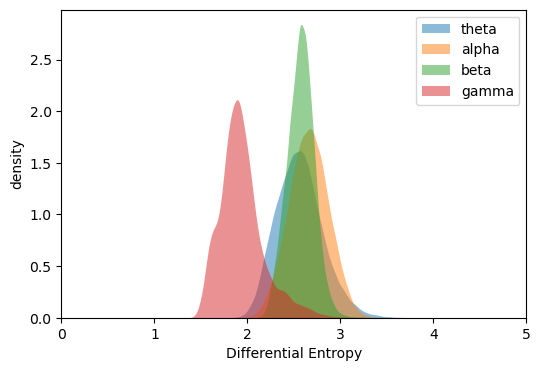

In [34]:
def plot_DE_density(samples, xlim=[0,5]):
    data_reshaped = samples.transpose((2, 0, 1)).reshape(4, -1).T
    df = pd.DataFrame(data_reshaped, columns=[band for band in band_dict.keys()])
    plt.figure(figsize=(6, 4))
    for band in band_dict.keys():
        sns.kdeplot(df[band], fill=True, common_norm=False, alpha=0.5, linewidth=0)
    plt.xlabel('Differential Entropy'); plt.ylabel('density'); plt.legend([band for band in band_dict.keys()])
    plt.xlim(xlim); plt.show()

subject_dataset = copy.copy(dataset)
subject_dataset.info = dataset.info[dataset.info['subject_id']==1]

plot_DE_density(get_x_from_dataset(subject_dataset, togrid))

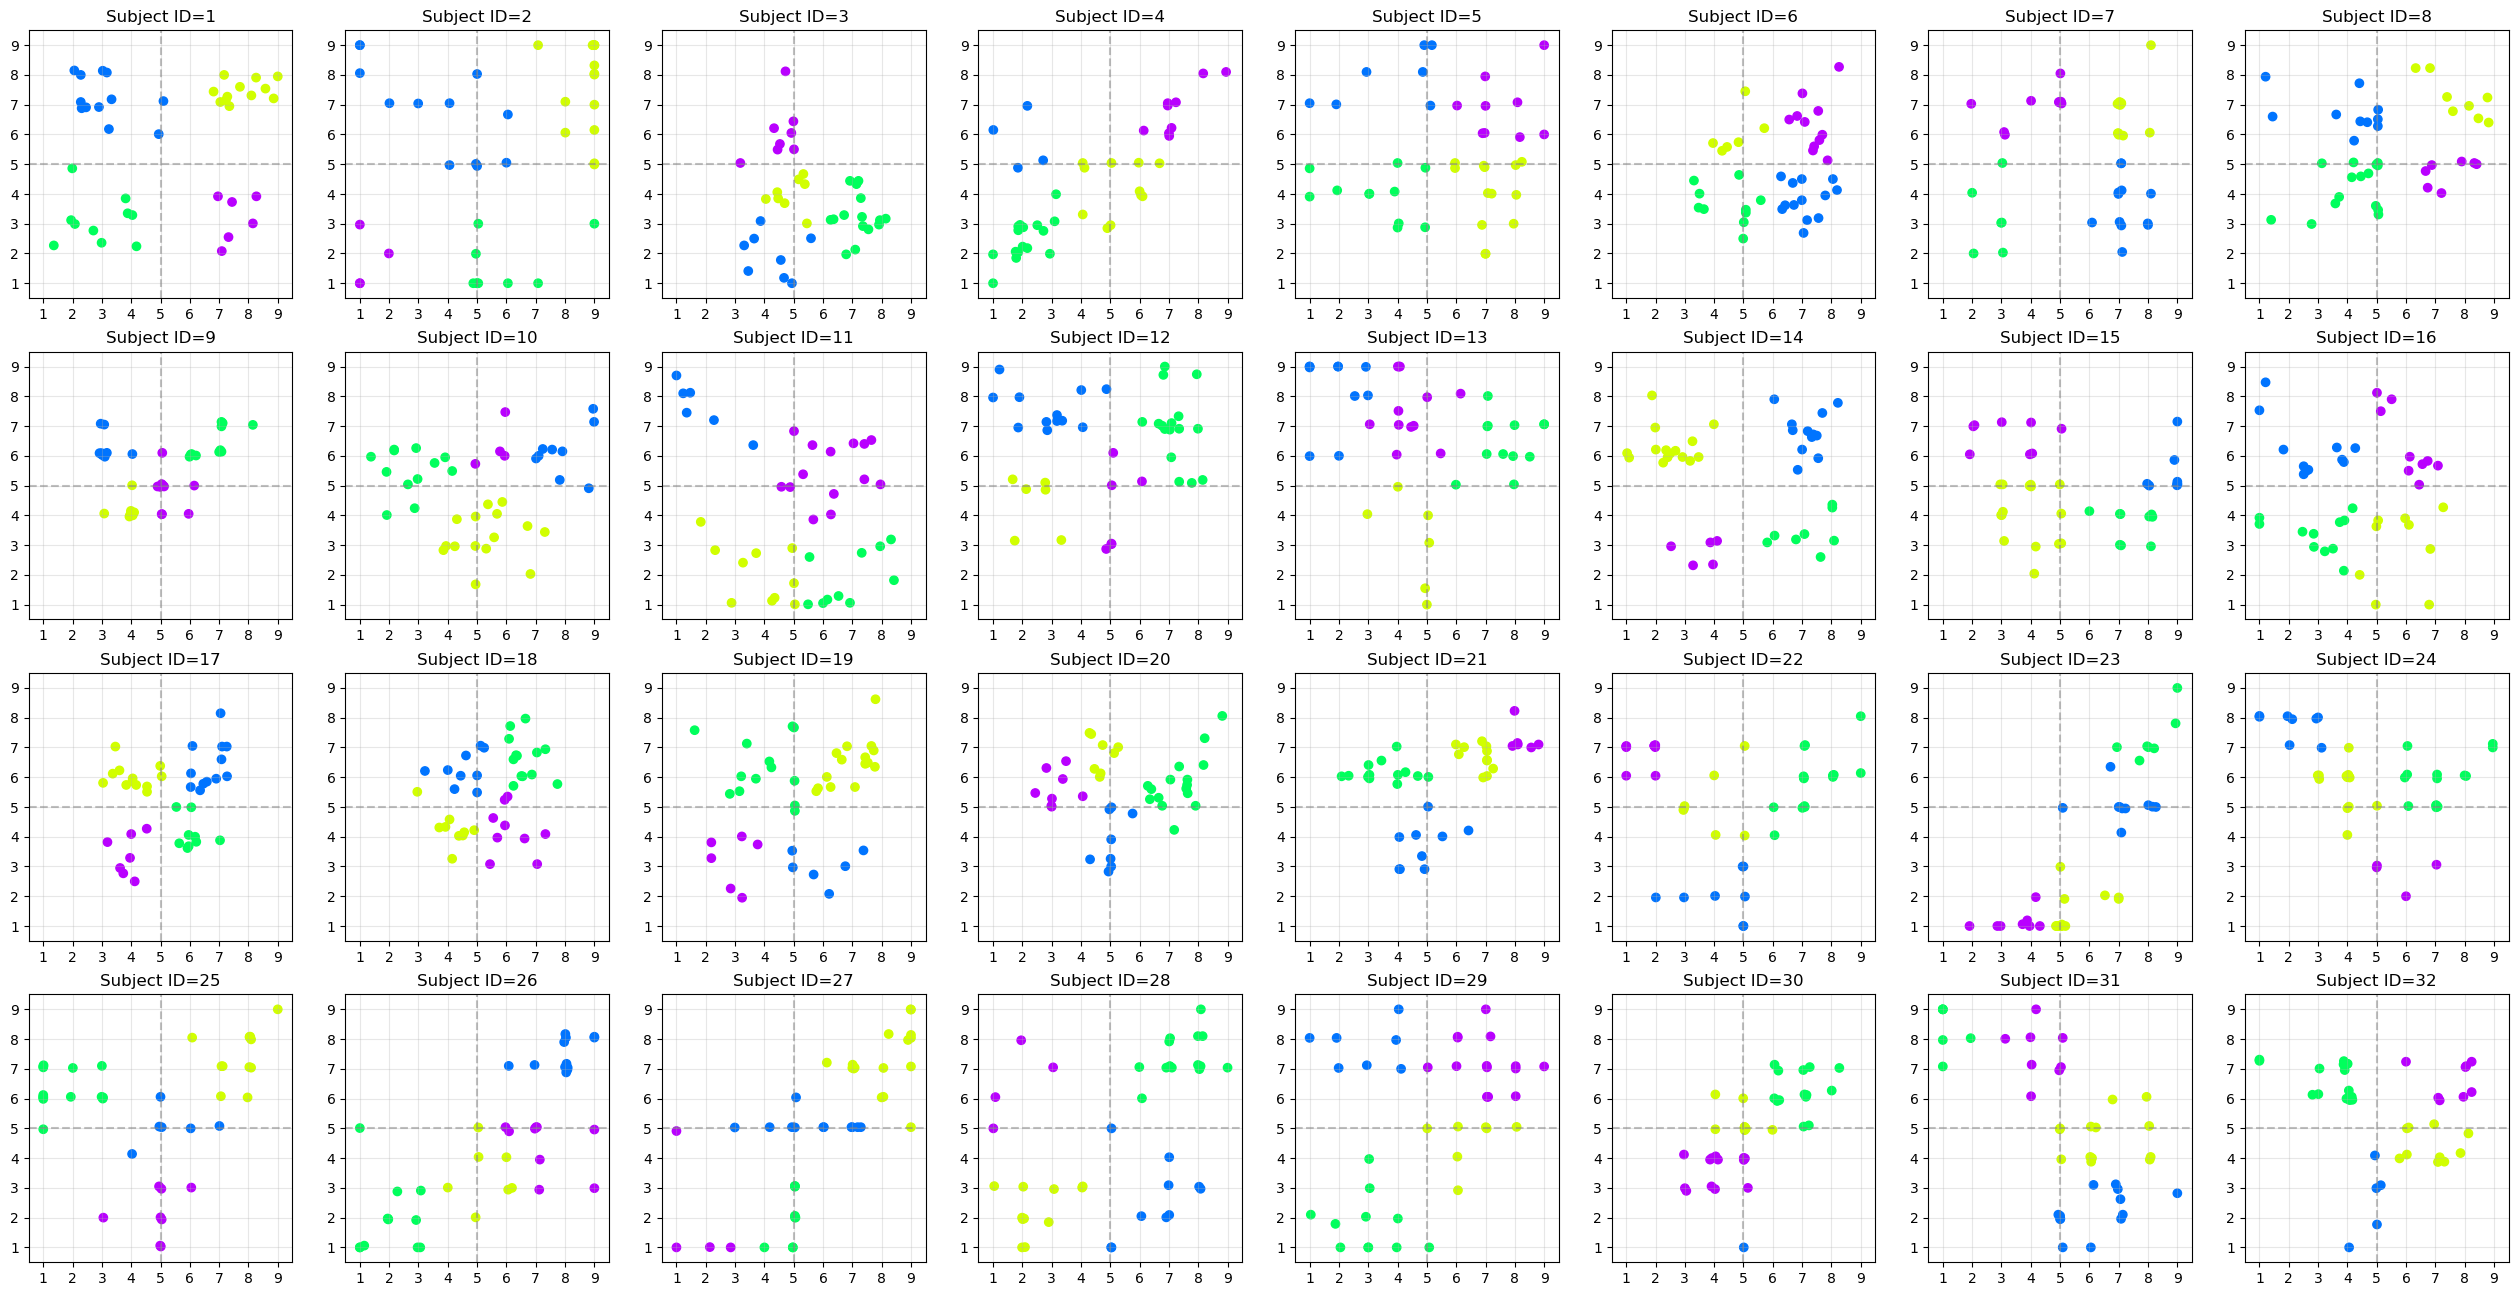

In [19]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

def plot_all_VA(dataset, n_clusters=4):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(32, 16))  
    subjects = dataset.info['subject_id'].unique()
    for i, subject in enumerate(subjects): 
        ax = axes[i // 8][i % 8]  
        subject_data = dataset.info[dataset.info['subject_id'] == subject]
        data = subject_data.groupby('trial_id').first().reset_index()
        data = data[['valence', 'arousal']]
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        data['cluster'] = kmeans.fit_predict(data[['valence', 'arousal']])
        palette = sns.color_palette('hsv', n_colors=n_clusters)
        cluster_colors = [palette[x] for x in data['cluster']]
        ax.axhline(y=5, color='grey', linestyle='--', alpha=0.5)
        ax.axvline(x=5, color='grey', linestyle='--', alpha=0.5)
        ax.scatter(data['valence'], data['arousal'], color=cluster_colors)
        ax.set_title(f'Subject ID={subject}')
        ax.set_xticks(range(1, 10)); ax.set_yticks(range(1, 10))
        ax.set_xlim(0.5, 9.5); ax.set_ylim(0.5, 9.5); ax.grid(True, alpha=0.3)
    plt.show()

plot_all_VA(dataset)
warnings.filterwarnings('default')

# Split train test (based on K-means Clustering)

In [26]:
import model_selection

split_path = os.path.join(os.path.dirname(preprocessed_path), f'{DATASET_NAME}_DE__4_grid_KM')
cv = model_selection.KMeansCrossTrialPerSubject(n_clusters=4, test_size=0.1, seed=0, split_path=split_path, info=dataset.info)

Already exists in split_path = /mnt/data/members/granularity/DEAP_DE__4_grid_KM


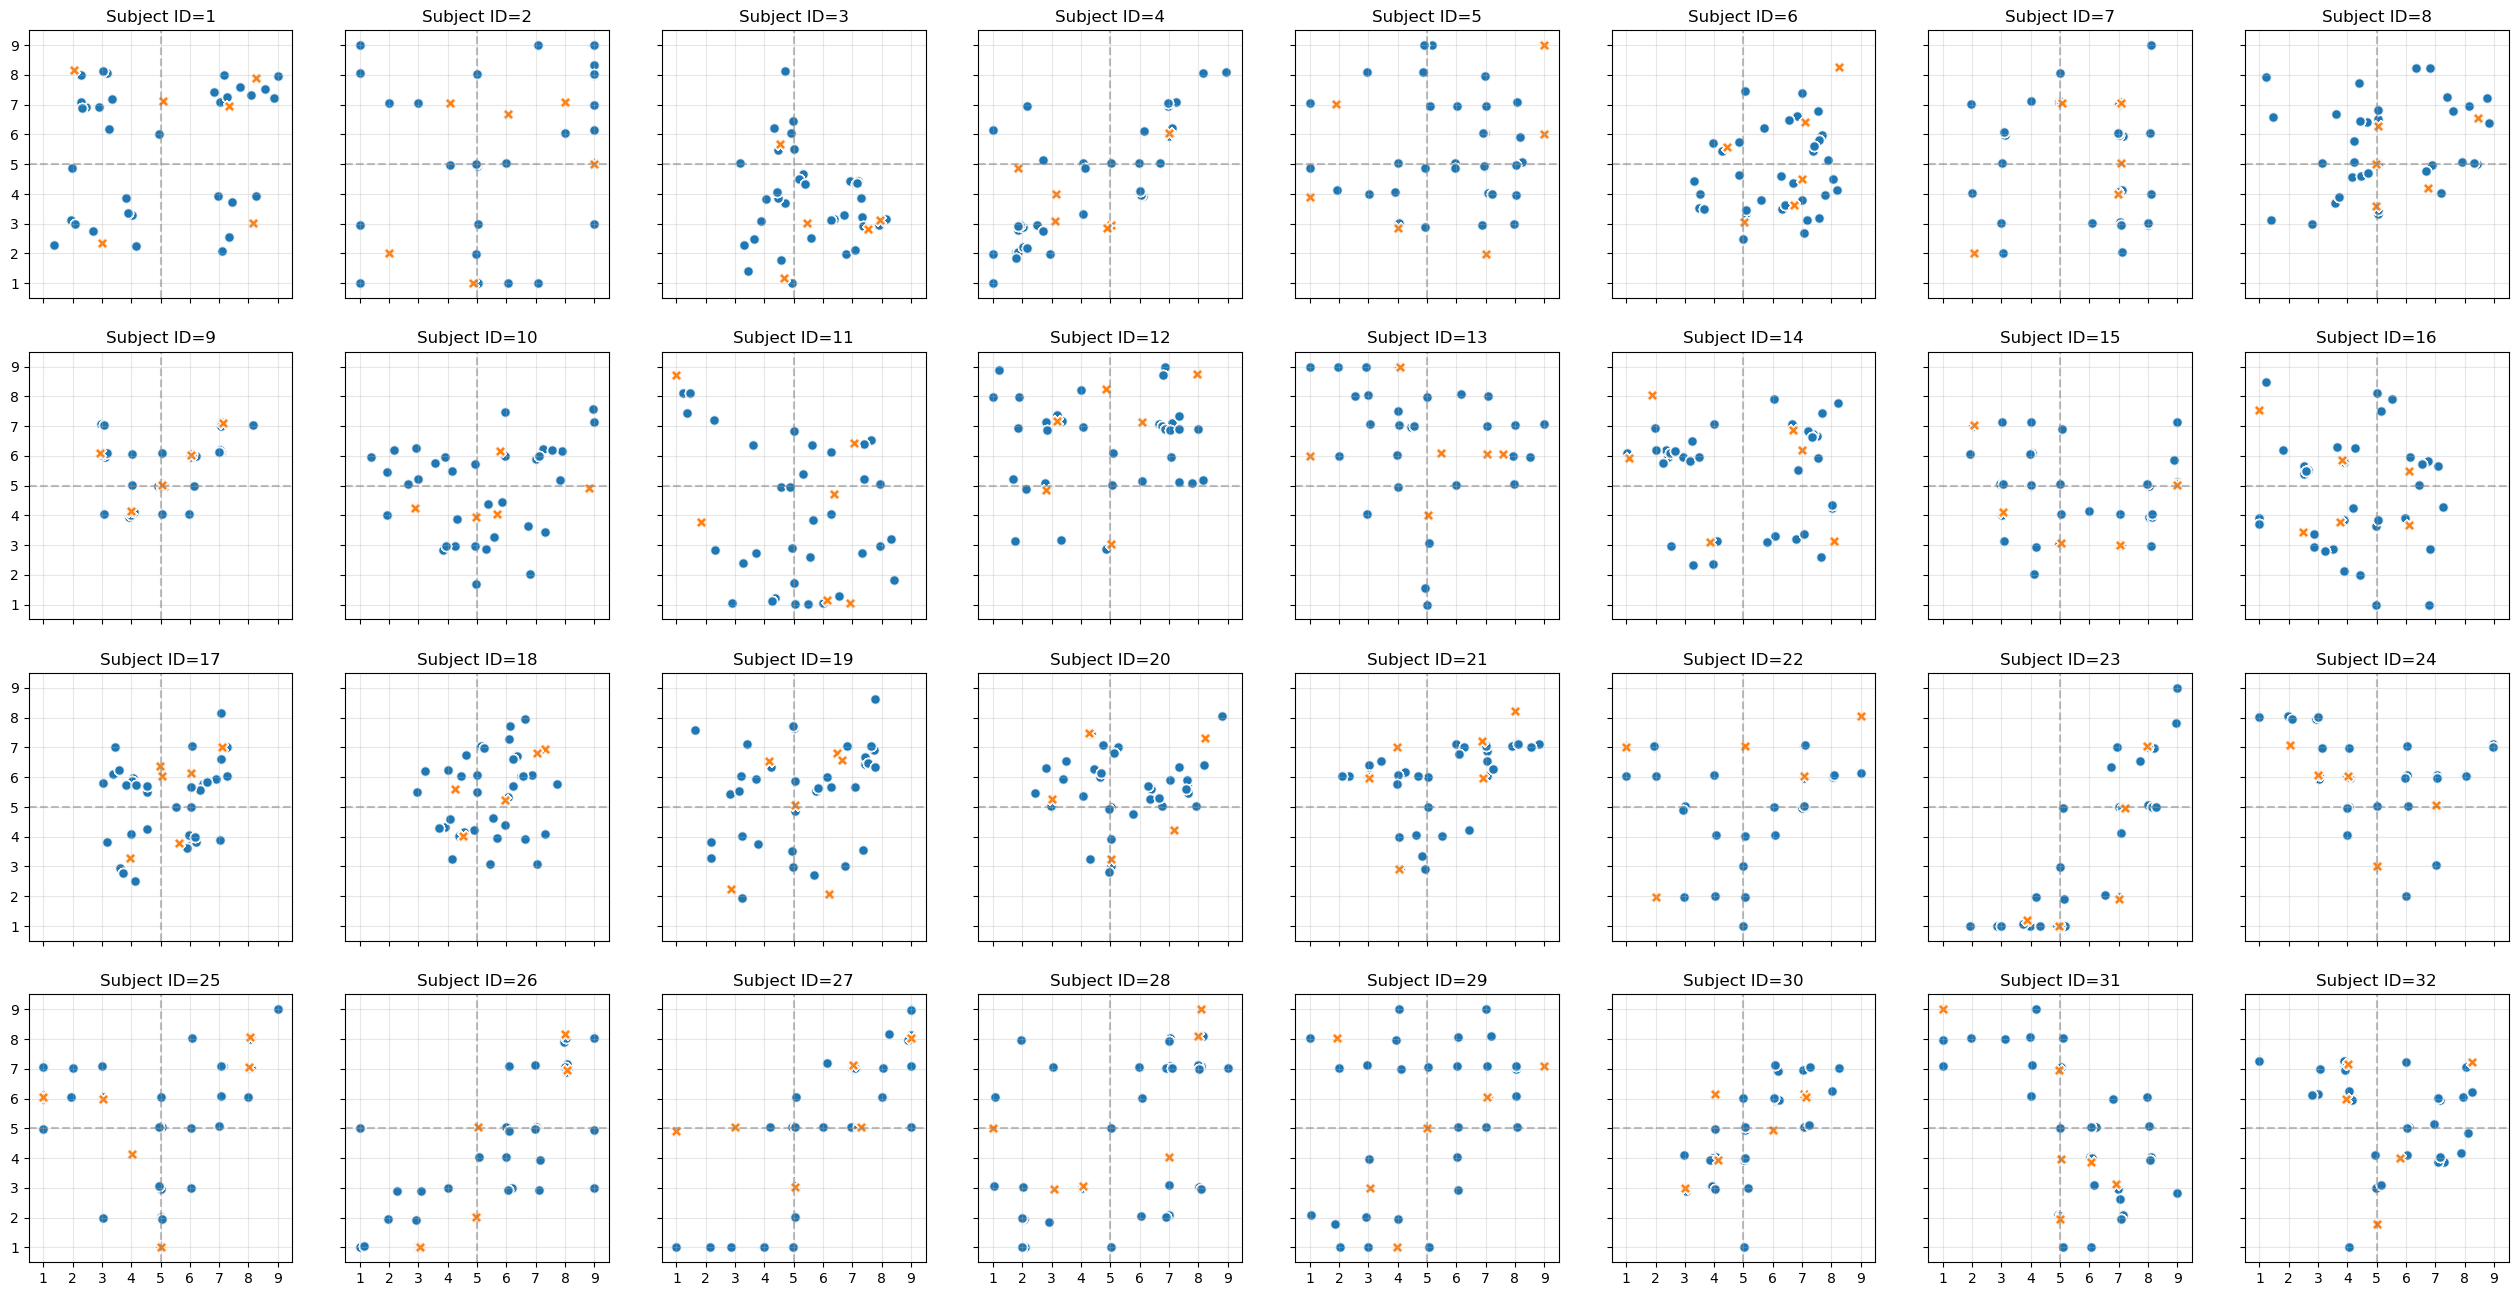

In [27]:
def plot_all_VA_train_test(cv, dataset):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(32, 16), sharex=True, sharey=True)
    subjects = dataset.info['subject_id'].unique()
    for i, subject in enumerate(subjects):
        ax = axes[i // 8][i % 8] 
        trainset, testset = cv.split(dataset, subject)
        train_data = trainset.info[['valence', 'arousal', 'cluster']]
        test_data = testset.info[['valence', 'arousal', 'cluster']]
        ax.axhline(y=5, color='grey', linestyle='--', alpha=0.5)
        ax.axvline(x=5, color='grey', linestyle='--', alpha=0.5)
        ax.scatter(train_data['valence'], train_data['arousal'], color='C0',
                   label='Train', alpha=0.7, marker='o', edgecolors='w', s=50)
        ax.scatter(test_data['valence'], test_data['arousal'], color='C1',
                   label='Test', alpha=0.7, marker='X', edgecolors='w', s=60)
        ax.set_title(f'Subject ID={subject}')
        ax.set_xticks(range(1, 10)); ax.set_yticks(range(1, 10))
        ax.set_xlim(0.5, 9.5); ax.set_ylim(0.5, 9.5); ax.grid(True, alpha=0.3)
    plt.show()

plot_all_VA_train_test(cv, dataset)

In [28]:
def to_categorical(y):
    categories = torch.zeros_like(y)
    categories[y < 4] = 0
    categories[(y >= 4) & (y <= 6)] = 1
    categories[y > 6] = 2
    return categories

def print_unique_count(dataset, subject):
    print(f'Subject ID = {subject}')
    trainset, testset = cv.split(dataset, subject)
    print('samples:', len(trainset), len(testset))
    for dimension in ['valence', 'arousal']:
        trainset.info[dimension] = to_categorical(torch.tensor(trainset.info[dimension].values))
        testset.info[dimension] = to_categorical(torch.tensor(testset.info[dimension].values))
        train_unique = sorted(trainset.info[dimension].unique())
        test_unique = sorted(testset.info[dimension].unique())
        train_counts = trainset.info[dimension].value_counts().to_dict()
        test_counts = testset.info[dimension].value_counts().to_dict()
        print('  Train Labels:', train_unique); print('   ', train_counts)
        print('  Test  Labels:', test_unique);  print('   ', test_counts)
print_unique_count(dataset, subject=1)

Subject ID = 1
samples: 918 162
  Train Labels: [0.0, 1.0, 2.0]
    {0.0: 432, 2.0: 405, 1.0: 81}
  Test  Labels: [0.0, 1.0, 2.0]
    {2.0: 81, 0.0: 54, 1.0: 27}
  Train Labels: [0.0, 1.0, 2.0]
    {2.0: 540, 0.0: 351, 1.0: 27}
  Test  Labels: [0.0, 2.0]
    {2.0: 108, 0.0: 54}


## Data Scaling

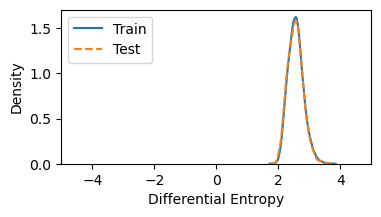

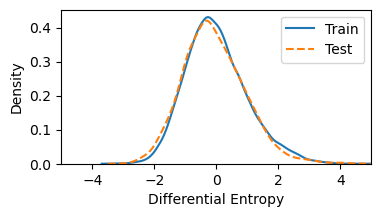

In [29]:
def get_mask(grid, freq=4):
    boolean_grid = [[item != '-' for item in row] for row in grid]
    return np.stack([boolean_grid] * freq)

def calculate_stats(dataset, togrid):
    x_samples = get_x_from_dataset(dataset, togrid)
    mean = np.mean(x_samples, axis=0);  std = np.std(x_samples, axis=0)    
    mean = togrid.apply(mean);  std = togrid.apply(std)
    return mean, std  

def plot_value_density(train_samples, test_samples):
    plt.figure(figsize=(4, 2))
    freq_i = 0
    sns.kdeplot(train_samples[:, :, freq_i].flatten(), label=f"Train", linestyle="-", color=f"C0")
    sns.kdeplot(test_samples[:, :, freq_i].flatten(), label=f"Test", linestyle="--", color=f"C1")
    plt.xlabel('Differential Entropy'); plt.xlim(-5,5)
    plt.ylabel('Density'); plt.legend(); plt.show()
    
trainset, testset = cv.split(dataset, subject=1)
plot_value_density(get_x_from_dataset(trainset, togrid), get_x_from_dataset(testset, togrid))
train_mean, train_std = calculate_stats(trainset, togrid); mask = get_mask(DEAP_LOCATION_LIST)
trainset.online_transform = transforms.Compose([tools.MeanStdNormalize_grid(train_mean, train_std, mask), transforms.ToTensor()])
testset.online_transform  = transforms.Compose([tools.MeanStdNormalize_grid(train_mean, train_std, mask), transforms.ToTensor()])
plot_value_density(get_x_from_dataset(trainset, togrid), get_x_from_dataset(testset, togrid))

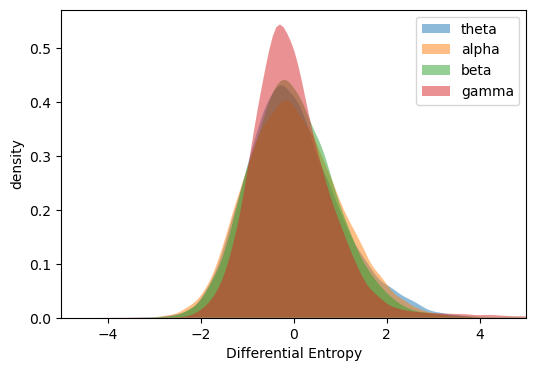

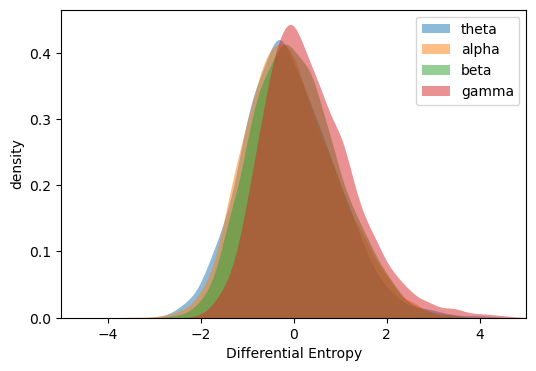

In [35]:
plot_DE_density(get_x_from_dataset(trainset, togrid), xlim=[-5,5])
plot_DE_density(get_x_from_dataset(testset, togrid), xlim=[-5,5])

# Model

In [36]:
import models

MODEL_NAME ='CCNN'
in_channels = dataset[0][0].shape[0]; dropout=0.5; 
Model = models.CCNN(in_channels=in_channels, dropout=dropout, out_size=2)
print(Model)

CCNN(
  (conv1): Sequential(
    (0): ZeroPad2d((1, 2, 1, 2))
    (1): Conv2d(4, 64, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ZeroPad2d((1, 2, 1, 2))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): ZeroPad2d((1, 2, 1, 2))
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): ZeroPad2d((1, 2, 1, 2))
    (1): Conv2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
  )
  (lin1): Sequential(
    (0): Linear(in_features=5184, out_features=1024, bias=True)
    (1): SELU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)


# Learning

In [37]:
# 회귀 기반 분류
## 회귀 모델 -> 연속적인 값 -> 분류 결정
## RMSE: valence, arousal, valence-arousal (두 차원 모두에 대해)
## Accuracy: valence, arousal, valence-arousal 

In [38]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__() 
        self.loss_fn = nn.MSELoss()
    def forward(self, y_pred, y):
        loss1 = self.loss_fn(y_pred[:, 0], y[:, 0]) 
        loss2 = self.loss_fn(y_pred[:, 1], y[:, 1]) 
        return torch.sqrt(loss1)*0.6 + torch.sqrt(loss2)*0.4

In [39]:
def train(dataloader, model, loss_fn, optimizer, device):
    epoch_loss, epoch_correct = 0, 0
    model.train()
    for (x, y) in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward(); optimizer.step()
        epoch_loss += loss.item()
        correct = torch.all(to_categorical(y_pred)==to_categorical(y), dim=1).sum().item()
        epoch_correct += correct
    epoch_loss /= len(dataloader); epoch_correct /= len(dataloader.dataset)
    return round(epoch_loss, 4), round(100 * epoch_correct, 2)

def test(dataloader, model, device):
    correct = 0; loss = 0; n_samples = len(dataloader.dataset)
    val_loss, aro_loss = 0.0, 0.0; val_correct, aro_correct = 0, 0
    model.eval()
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += nn.functional.mse_loss(y_pred.view(-1), y.view(-1), reduction='sum').item()
            val_loss += nn.functional.mse_loss(y_pred[:, 0], y[:, 0], reduction='sum').item()
            aro_loss += nn.functional.mse_loss(y_pred[:, 1], y[:, 1], reduction='sum').item() 
            correct += torch.all(to_categorical(y_pred)==to_categorical(y), dim=1).sum().item()
            val_correct += (to_categorical(y_pred)[:, 0]==to_categorical(y)[:, 0]).sum().item()
            aro_correct += (to_categorical(y_pred)[:, 1]==to_categorical(y)[:, 1]).sum().item()
    loss = np.sqrt(loss / n_samples)
    val_loss = np.sqrt(val_loss / n_samples); aro_loss = np.sqrt(aro_loss / n_samples)
    acc = 100 * (correct / n_samples)
    val_acc = 100 * (val_correct / n_samples); aro_acc = 100 * (aro_correct / n_samples)
    return {'loss': round(loss, 4), 'acc': round(acc, 2),
            'val_RMSE': round(val_loss, 4), 'aro_RMSE': round(aro_loss, 4),
            'val_acc': round(val_acc, 2), 'aro_acc': round(aro_acc, 2)}
    
def plot_train_log(train_losses, train_accs, path=os.getcwd(), flag=1):
    fig, loss_ax = plt.subplots(figsize=(10,4))
    acc_ax = loss_ax.twinx()
    xran = range(1, len(train_losses)+1)
    loss_ax.plot(xran, train_losses, 'y', label = 'train loss')
    acc_ax.plot(xran, train_accs, 'b', label = 'train ACC')
    loss_ax.set_xlabel('epoch'); loss_ax.set_ylabel('Loss'); acc_ax.set_ylabel('Accuracy')
    loss_ax.legend(loc='upper left'); acc_ax.legend(loc='lower left')
    plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(path, f'train_log_{flag}.png'))

In [42]:
EXPER_SET = 'SD_VA';
exper_path = os.path.join(os.getcwd(), "OUT", f'{DATASET_NAME} {EXPER_SET}')
exper_model_path = os.path.join(exper_path, f'{MODEL_NAME}')

def run_train(subject):
    print(f'Test Subject ID = {subject}======================================================')
    result_path = Path(os.path.join(exper_model_path, str(subject)))
    result_path.mkdir(parents=True, exist_ok=True)

    start = time.monotonic()
    trainset, testset = cv.split(dataset, subject)
    train_mean, train_std = calculate_stats(trainset, togrid); mask = get_mask(DEAP_LOCATION_LIST)
    trainset.online_transform = transforms.Compose([tools.MeanStdNormalize_grid(train_mean, train_std, mask), transforms.ToTensor()])
    testset.online_transform  = transforms.Compose([tools.MeanStdNormalize_grid(train_mean, train_std, mask), transforms.ToTensor()])
    train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = copy.deepcopy(Model).to(device)
    loss_fn = CustomLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001)
    with open(os.path.join(result_path, f'train_{subject}.txt'), 'w') as f:
        f.write(f'[train test] [{len(trainset)} {len(testset)}] batch:{BATCH_SIZE} lr:{LR}\n'
                f'Epoch_{EPOCH}_time \t Train_Loss \t Train_ACC \n')
        print(f'\tEpoch_{EPOCH}_time \t Train_Loss \t Train_ACC ')
        train_losses, train_accs = [], []
        best_train_loss = float('inf'); best_train_acc = 0
        for epoch in range(EPOCH):
            start_time = time.monotonic()
            train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
            train_losses.append(train_loss); train_accs.append(train_acc)
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                torch.save(model.state_dict(), os.path.join(result_path, f'best_train_{subject}.pt'))
                best_epoch = epoch
            end_time = time.monotonic(); epoch_mins, epoch_secs = tools.epoch_time(start_time, end_time)
            log = f'{epoch+1:03} {epoch_secs:2d}s \t{train_loss} \t{train_acc}'
            f.write(log+'\n'); print('\t'+log)
        plot_train_log(train_losses, train_accs, path=result_path, flag=f'{subject}')
        print(f"\tmodel weights saved in '{os.path.join(result_path, f'best_train_{subject}.pt')}")
    model.load_state_dict(torch.load(os.path.join(result_path, f'best_train_{subject}.pt')))

    result = test(test_loader, model, device)
    result['subject'] = subject; result['epoch'] = best_epoch;
    result_io = MetaInfoIO(os.path.join(result_path, f'result.csv'));  result_io.write_info(result)
    
    end = time.monotonic(); min, sec = tools.epoch_time(start, end)
    print(f'time: {min} min {sec} sec\n{result}')

Test Subject ID = 14======================================================
	Epoch_200_time 	 Train_Loss 	 Train_ACC 
	001  0s 	2.8275 	8.61
	002  1s 	2.0797 	5.45
	003  0s 	1.9563 	7.08
	004  0s 	1.8793 	9.8
	005  0s 	1.8684 	12.31
	006  1s 	1.8282 	14.05
	007  0s 	1.7676 	16.78
	008  0s 	1.7015 	19.72
	009  1s 	1.6747 	18.19
	010  0s 	1.62 	23.53
	011  0s 	1.6193 	21.79
	012  0s 	1.5637 	26.25
	013  1s 	1.4994 	27.45
	014  0s 	1.3877 	34.97
	015  0s 	1.325 	34.2
	016  0s 	1.3132 	35.4
	017  0s 	1.2692 	38.89
	018  0s 	1.1546 	41.94
	019  0s 	1.094 	46.51
	020  0s 	1.0331 	47.82
	021  0s 	1.0097 	49.89
	022  0s 	0.8889 	52.94
	023  0s 	0.8357 	55.77
	024  0s 	0.8125 	57.08
	025  0s 	0.7888 	57.41
	026  0s 	0.7729 	59.69
	027  0s 	0.6941 	61.98
	028  0s 	0.683 	65.03
	029  0s 	0.6322 	66.12
	030  0s 	0.5321 	71.46
	031  0s 	0.5299 	69.39
	032  0s 	0.5536 	66.56
	033  0s 	0.521 	71.79
	034  0s 	0.5082 	71.79
	035  0s 	0.4685 	72.88
	036  1s 	0.4581 	74.4
	037  0s 	0.4958 	73.97
	038  0s 

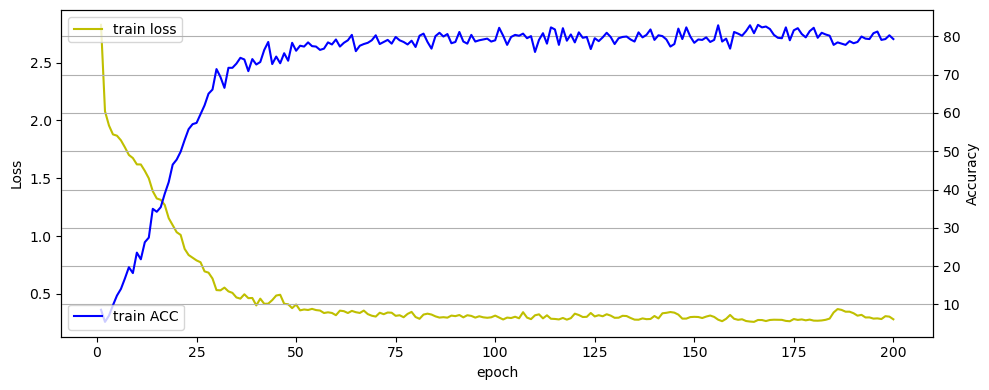

In [81]:
LR = 0.001; BATCH_SIZE = 64; EPOCH = 200
run_train(subject=14)

# Predict

In [82]:
def predict(dataloader, model, device):
    correct = 0; loss = 0; n_samples = len(dataloader.dataset)
    val_loss, aro_loss = 0.0, 0.0; val_correct, aro_correct = 0, 0
    preds, ys = [], []
    model.eval()
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            preds.append(y_pred.cpu().numpy()); ys.append(y.cpu().numpy())
            loss += nn.functional.mse_loss(y_pred.view(-1), y.view(-1), reduction='sum').item()
            val_loss += nn.functional.mse_loss(y_pred[:, 0], y[:, 0], reduction='sum').item()
            aro_loss += nn.functional.mse_loss(y_pred[:, 1], y[:, 1], reduction='sum').item() 
            correct += torch.all(to_categorical(y_pred)==to_categorical(y), dim=1).sum().item()
            val_correct += (to_categorical(y_pred)[:, 0]==to_categorical(y)[:, 0]).sum().item()
            aro_correct += (to_categorical(y_pred)[:, 1]==to_categorical(y)[:, 1]).sum().item()
    preds = np.concatenate(preds, axis=0); ys = np.concatenate(ys, axis=0)
    loss = np.sqrt(loss / n_samples)
    val_loss = np.sqrt(val_loss / n_samples); aro_loss = np.sqrt(aro_loss / n_samples)
    acc = 100 * (correct / n_samples)
    val_acc = 100 * (val_correct / n_samples); aro_acc = 100 * (aro_correct / n_samples)
    print({'loss': round(loss, 4), 'acc': round(acc, 2),
            'val_RMSE': round(val_loss, 4), 'aro_RMSE': round(aro_loss, 4),
            'val_acc': round(val_acc, 2), 'aro_acc': round(aro_acc, 2)})
    return preds, ys

In [83]:
def run_predict(subject):
    trainset, testset = cv.split(dataset, subject)
    print(f'Test Subject ID = {subject}\t{len(testset)} samples' )
    for dimension in ['valence', 'arousal']:
        testset.info[f'{dimension}_c'] = to_categorical(torch.tensor(testset.info[dimension].values))
        test_unique = sorted(testset.info[f'{dimension}_c'].unique())
        test_counts = testset.info[f'{dimension}_c'].value_counts().to_dict()
        print(f'  {dimension} {test_unique}\t{test_counts}')
    train_mean, train_std = calculate_stats(trainset, togrid); mask = get_mask(DEAP_LOCATION_LIST)
    testset.online_transform = transforms.Compose([tools.MeanStdNormalize_grid(train_mean, train_std, mask), transforms.ToTensor()])
    test_loader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)
    model = copy.deepcopy(Model).to(device)
    model.load_state_dict(torch.load(os.path.join(exper_model_path, str(subject), f'best_train_{subject}.pt')))
    preds, ys = predict(test_loader, model, device)
    return preds, ys, testset.info
    
preds, ys, test_info = run_predict(subject=14)

Test Subject ID = 14	162 samples
  valence [0.0, 2.0]	{0.0: 81, 2.0: 81}
  arousal [0.0, 1.0, 2.0]	{2.0: 81, 0.0: 54, 1.0: 27}
{'loss': 3.0884, 'acc': 21.6, 'val_RMSE': 2.4417, 'aro_RMSE': 1.8912, 'val_acc': 58.64, 'aro_acc': 37.04}


In [84]:
trial_s = 0; trial_num = 6
trial_ids = torch.tensor(test_info['trial_id'])
diff = trial_ids[1:] != trial_ids[:-1] # 텐서에서 값이 변하는 지점을 찾음
changes = torch.cat([torch.tensor([True]), diff])
change_indices = torch.where(changes)[0] # 변화가 있는 지점의 인덱스를 구함
trial_counts = torch.diff(torch.cat([change_indices, torch.tensor([len(trial_ids)])]))
cut1 = sum(trial_counts[ : trial_s]); cut2 = sum(trial_counts[ : trial_s+trial_num])
print(trial_counts[trial_s:trial_s+trial_num]); print(cut1, cut2)

tensor([27, 27, 27, 27, 27, 27])
0 tensor(162)


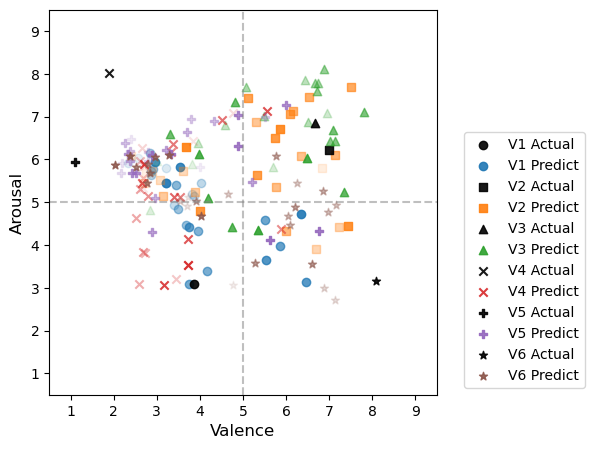

In [85]:
def predict_space(trial_counts, preds, ys):
    plt.figure(figsize=(5, 5))
    plt.axhline(y=5, color='grey', linestyle='--', alpha=0.5)
    plt.axvline(x=5, color='grey', linestyle='--', alpha=0.5)
    markers = ['o', 's', '^', 'x', 'P','*']
    for t, i in enumerate(trial_counts):
        s = t * i ;    e = i * (t + 1);
        alphas = np.linspace(0.1, 0.9, e - s) # 처음(연함) 끝 (진함)
        for idx, (yc, pc, alpha) in enumerate(zip(ys[s:e], preds[s:e], alphas)):
            if idx == e - s - 1:
                plt.scatter(yc[0], yc[1], color='k', alpha=0.9, marker=markers[t], label=f'V{t+1} Actual')
                plt.scatter(pc[0], pc[1], color=f'C{t}', alpha=alpha, marker=markers[t], label=f'V{t+1} Predict')
            else:
                plt.scatter(pc[0], pc[1], color=f'C{t}', alpha=alpha, marker=markers[t])
    plt.xlabel('Valence', fontsize=12); plt.ylabel('Arousal', fontsize=12)
    plt.xlim(0.5, 9.5);  plt.ylim(0.5, 9.5)
    plt.xticks(range(1, 10)); plt.yticks(range(1, 10)); 
    plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.)); plt.show()
predict_space(trial_counts[trial_s:trial_s+trial_num], preds[cut1:cut2], ys[cut1:cut2])

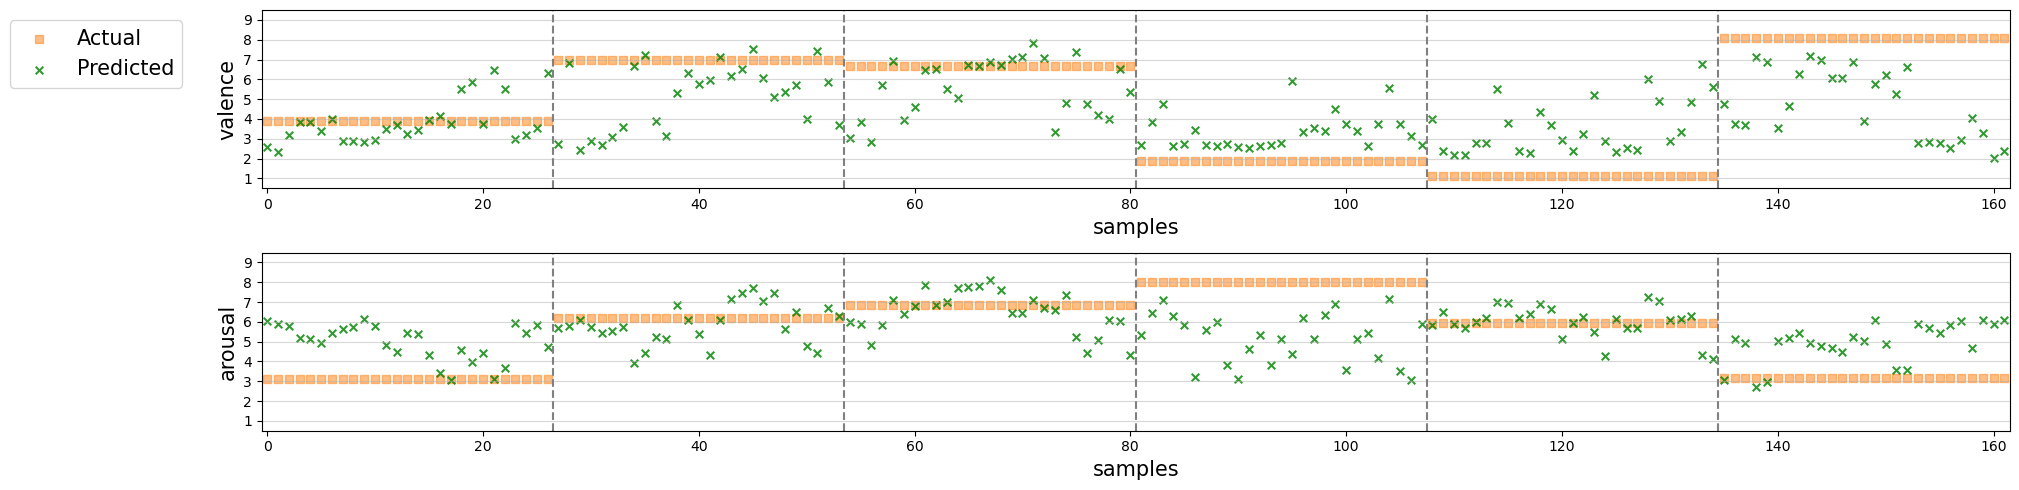

In [86]:
def predict_sample(trial_counts, preds, ys):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5)) 
    
    trial_end = np.cumsum(trial_counts)  # 각 trial 경계에 세로 선 그리기
    for end in trial_end[:-1]:
        ax1.axvline(x=end-0.5, color='grey', linestyle='--'); ax2.axvline(x=end-0.5, color='grey', linestyle='--')
    # Valence
    ax1.scatter(np.arange(len(ys)), ys[:,0], label='Actual', color='C1', marker='s', alpha=0.5, s=30)
    ax1.scatter(np.arange(len(ys)), preds[:,0], label='Predicted', color='g', marker='x', alpha=0.8, s=30)
    # Arousal 
    ax2.scatter(np.arange(len(ys)), ys[:,1], label='Actual', color='C1', marker='s', alpha=0.5, s=30)
    ax2.scatter(np.arange(len(ys)), preds[:,1], label='Predicted', color='g', marker='x', alpha=0.8, s=30)
    
    ax1.set_yticks(range(1, 10)); ax1.set_ylim(0.5, 9.5); ax1.set_xlim(left=-0.5, right=len(ys)-0.5)
    ax2.set_yticks(range(1, 10)); ax2.set_ylim(0.5, 9.5); ax2.set_xlim(left=-0.5, right=len(ys)-0.5)
    ax1.set_ylabel('valence', fontsize=15); ax1.set_xlabel('samples', fontsize=15);
    ax2.set_ylabel('arousal', fontsize=15); ax2.set_xlabel('samples', fontsize=15);
    ax1.grid(axis='y', alpha=0.5); ax2.grid(axis='y', alpha=0.5);

    ax1.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.), fontsize=15); 
    plt.tight_layout(); plt.show()
predict_sample(trial_counts[trial_s:trial_s+trial_num], preds[cut1:cut2], ys[cut1:cut2])